* Primero importamos las librerias necesarias 


In [4]:

import sqlite3
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm
import numpy as np
import os
import time
import re

Procederemos a la creación de las bases de datos, para ello utilizaremos los archivos csv resultadosCSV y resultados_viejos para hacer dos bases de datos individuales, una para los datos 2010-2015 y otra para 2019-2024, anteriormente obtenidos de la web de MeteoGalicia.

In [ ]:
### Leer el archivo CSV
csv_file = "resultados_viejos.csv"
data = pd.read_csv(csv_file)

### Asegurarnos de que la columna Data existe (Me dio problemas porque "Data" es "Fecha" en gallego y no me di cuenta que asi estaba puesto)
if "Data" not in data.columns:
    raise ValueError("Data no esta")

### Mantener el nombre original de "Data" y otras columnas relevantes
data = data[["Data", "Parámetro", "Valor"]]
data.columns = ["Data", "parametro", "valor"]

### Elegimos el nombre del archivo de la base de datos
db_file = 'resultadoDBold.sqlite'

### Función para manejar bloqueos de la base de datos
def connect_with_retry(db_file, retries=5, delay=1):
    for i in range(retries):
        try:
            return sqlite3.connect(db_file)
        except sqlite3.OperationalError as e:
            if "locked" in str(e).lower():
                print(f"Database is locked, retrying ({i + 1}/{retries})...")
                time.sleep(delay)
            else:
                raise
    raise sqlite3.OperationalError("Database is locked after multiple retries.")

### Función para limpiar nombres de tablas y columnas
def clean_name(name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', name)

### Conectar o crear la base de datos SQLite
conn = connect_with_retry(db_file)
cursor = conn.cursor()

### Crear tabla FECHA con la columna correcta
cursor.execute("""
CREATE TABLE IF NOT EXISTS FECHA (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Data TEXT UNIQUE
);
""")

### Insertar fechas únicas en la tabla FECHA (Ajuste por si acaso la fecha esta repetida)
fechas_unicas = pd.DataFrame(data['Data'].unique(), columns=['Data'])
for _, row in fechas_unicas.iterrows():
    try:
        cursor.execute("INSERT OR IGNORE INTO FECHA (Data) VALUES (?);", (row['Data'],))
    except sqlite3.IntegrityError as e:
        print(f"Error inserting date {row['Data']}: {e}")

### Recuperar las fechas con sus IDs generados (La columna Id hubo que mantenerla porque sino daba errores)
df_fechas = pd.read_sql("SELECT * FROM FECHA", conn)

### Crear tabla PARAMETROS_PRINCIPALES para poder unirla con el resto
cursor.execute("""
CREATE TABLE IF NOT EXISTS PARAMETROS_PRINCIPALES (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nombre TEXT UNIQUE
);
""")

### Crear tabla PARAMETROS_SECUNDARIOS
cursor.execute("""
CREATE TABLE IF NOT EXISTS PARAMETROS_SECUNDARIOS (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    principal_id INTEGER,
    nombre TEXT UNIQUE,
    FOREIGN KEY(principal_id) REFERENCES PARAMETROS_PRINCIPALES(id)
);
""")

### Identificamos los parametros secundarios y principales
parametros_principales = {
    'Temperatura': ['Temperatura media', 'Temperatura máxima', 'Temperatura mínima'],
    'Humedad': ['Humedad relativa', 'Humedad absoluta'],
    'Precipitación': ['Chuvia', 'Lluvia acumulada'],
    'Viento': ['Velocidad del viento', 'Dirección del viento', 'Ráfagas'],
    'Presión': ['Presión atmosférica'],
    'Radiación': ['Radiación solar'],
}

### Insertamos los parametros principales y secundarios.
for principal, secundarios in parametros_principales.items():
    # Insertar parámetro principal
    cursor.execute("INSERT OR IGNORE INTO PARAMETROS_PRINCIPALES (nombre) VALUES (?);", (principal,))
    cursor.execute("SELECT id FROM PARAMETROS_PRINCIPALES WHERE nombre = ?;", (principal,))
    principal_id = cursor.fetchone()[0]

    # Insertar parámetros secundarios
    for secundario in secundarios:
        cursor.execute("INSERT OR IGNORE INTO PARAMETROS_SECUNDARIOS (principal_id, nombre) VALUES (?, ?);", (principal_id, secundario))

### Creacion de tablas secundarias cpn distinciones para identificarla con su tabla principal
for parametro in data['parametro'].unique():
    ### Determinar a que categoria pertenece cada tabla secundaria
    for principal, secundarios in parametros_principales.items():
        if parametro in secundarios:
            table_name = clean_name(parametro)

            ### Creamos una tabla especifica para cada parametro secundario
            cursor.execute(f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                fecha_id INTEGER,
                valor REAL,
                FOREIGN KEY(fecha_id) REFERENCES FECHA(id)
            );
            """)

            ### Filtramos los datos para este parametro
            subset = data[data['parametro'] == parametro][['Data', 'valor']]

            ### Mapeamos las fechas a fecha_id usando la tabla Data
            subset = subset.merge(df_fechas, left_on='Data', right_on='Data')
            subset = subset.rename(columns={'id': 'fecha_id'})
            subset = subset[['fecha_id', 'valor']]

            ### Insertar datos en la tabla que queremos porque en el archivo CSV estan mal ordenadas
            subset.to_sql(table_name, conn, if_exists='append', index=False)

### Confirmar cambios y cerrar conexión
conn.commit()
conn.close()
### Mensaje para indicar q todo bien
print('Base de datos creada correctamente')

Base de datos creada correctamente


Ahora vamos a hacer lo mismo pero para la BD de los datos mas nuevos 

In [10]:

csv_file = "resultadoCSV.csv"
data = pd.read_csv(csv_file)

if "Data" not in data.columns:
    raise ValueError("Data no esta")

data = data[["Data", "Parámetro", "Valor"]]
data.columns = ["Data", "parametro", "valor"]

db_file = 'resultadoDBold.sqlite'

def connect_with_retry(db_file, retries=5, delay=1):
    for i in range(retries):
        try:
            return sqlite3.connect(db_file)
        except sqlite3.OperationalError as e:
            if "locked" in str(e).lower():
                print(f"Database is locked, retrying ({i + 1}/{retries})...")
                time.sleep(delay)
            else:
                raise
    raise sqlite3.OperationalError("Database is locked after multiple retries.")

def clean_name(name):
    return re.sub(r'[^a-zA-Z0-9_]', '_', name)

conn = connect_with_retry(db_file)
cursor = conn.cursor()

cursor.execute("""
CREATE TABLE IF NOT EXISTS FECHA (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    Data TEXT UNIQUE
);
""")

fechas_unicas = pd.DataFrame(data['Data'].unique(), columns=['Data'])
for _, row in fechas_unicas.iterrows():
    try:
        cursor.execute("INSERT OR IGNORE INTO FECHA (Data) VALUES (?);", (row['Data'],))
    except sqlite3.IntegrityError as e:
        print(f"Error inserting date {row['Data']}: {e}")

df_fechas = pd.read_sql("SELECT * FROM FECHA", conn)

cursor.execute("""
CREATE TABLE IF NOT EXISTS PARAMETROS_PRINCIPALES (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    nombre TEXT UNIQUE
);
""")

cursor.execute("""
CREATE TABLE IF NOT EXISTS PARAMETROS_SECUNDARIOS (
    id INTEGER PRIMARY KEY AUTOINCREMENT,
    principal_id INTEGER,
    nombre TEXT UNIQUE,
    FOREIGN KEY(principal_id) REFERENCES PARAMETROS_PRINCIPALES(id)
);
""")

parametros_principales = {
    'Temperatura': ['Temperatura media', 'Temperatura máxima', 'Temperatura mínima'],
    'Humedad': ['Humedad relativa', 'Humedad absoluta'],
    'Precipitación': ['Chuvia', 'Lluvia acumulada'],
    'Viento': ['Velocidad del viento', 'Dirección del viento', 'Ráfagas'],
    'Presión': ['Presión atmosférica'],
    'Radiación': ['Radiación solar'],
}

for principal, secundarios in parametros_principales.items():
    
    cursor.execute("INSERT OR IGNORE INTO PARAMETROS_PRINCIPALES (nombre) VALUES (?);", (principal,))
    cursor.execute("SELECT id FROM PARAMETROS_PRINCIPALES WHERE nombre = ?;", (principal,))
    principal_id = cursor.fetchone()[0]

    for secundario in secundarios:
        cursor.execute("INSERT OR IGNORE INTO PARAMETROS_SECUNDARIOS (principal_id, nombre) VALUES (?, ?);", (principal_id, secundario))

for parametro in data['parametro'].unique():
    
    for principal, secundarios in parametros_principales.items():
        if parametro in secundarios:
            table_name = clean_name(parametro)

 
            cursor.execute(f"""
            CREATE TABLE IF NOT EXISTS {table_name} (
                id INTEGER PRIMARY KEY AUTOINCREMENT,
                fecha_id INTEGER,
                valor REAL,
                FOREIGN KEY(fecha_id) REFERENCES FECHA(id)
            );
            """)

            subset = data[data['parametro'] == parametro][['Data', 'valor']]

            subset = subset.merge(df_fechas, left_on='Data', right_on='Data')
            subset = subset.rename(columns={'id': 'fecha_id'})
            subset = subset[['fecha_id', 'valor']]

            subset.to_sql(table_name, conn, if_exists='append', index=False)
conn.commit()
conn.close()

print("Base de datos creada correctamente")

Base de datos creada correctamente


* Ahora vamos a realizar el muestreo de datos para poder realizar un analisis de las variables dentro de las tablas con la finalidad de poder visualizar los datos mas facilmente



Analizando la base de datos: resultadoDBold.sqlite
Tablas existentes en la base de datos: ['FECHA', 'sqlite_sequence', 'PARAMETROS_PRINCIPALES', 'PARAMETROS_SECUNDARIOS', 'Chuvia', 'Temperatura_media', 'Temperatura_máxima', 'Temperatura_mínima', 'Humedad_relativa', 'Humedad_absoluta', 'Dirección_del_viento']
Tablas válidas para análisis: ['Temperatura_mínima', 'Chuvia', 'Temperatura_media', 'Temperatura_máxima', 'Humedad_relativa', 'Dirección_del_viento']
Analizando la tabla: Temperatura_mínima


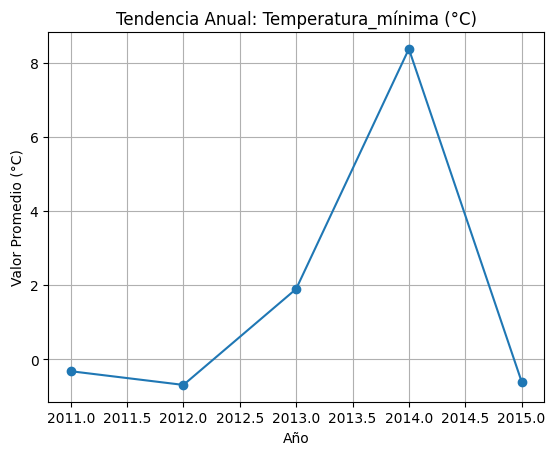

Analizando la tabla: Chuvia


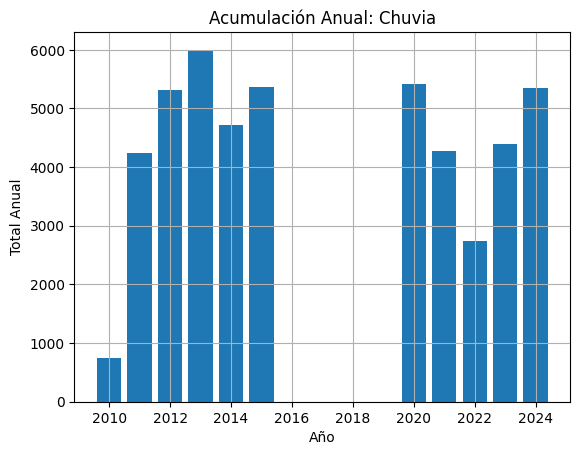

Analizando la tabla: Temperatura_media
Valores descartados en Temperatura_media: 0


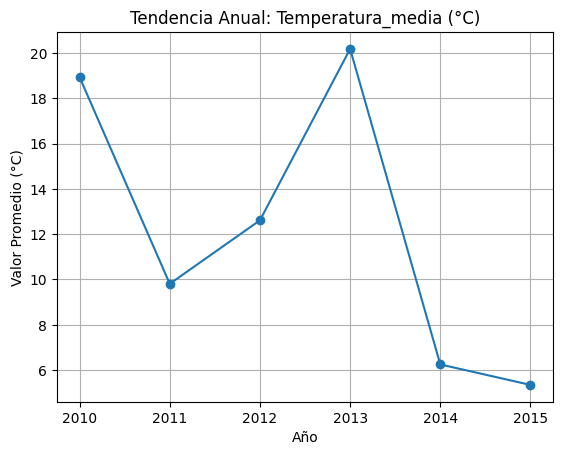

Analizando la tabla: Temperatura_máxima


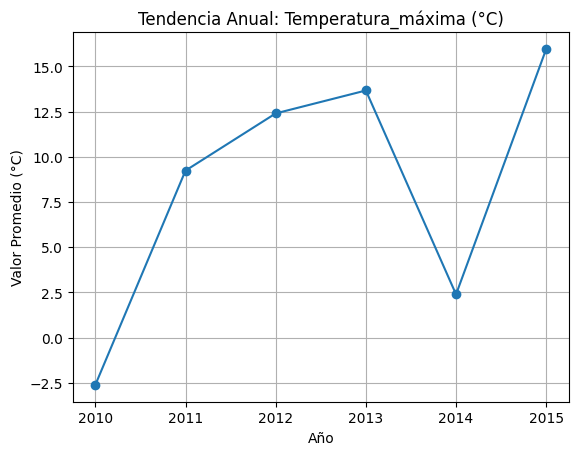

Analizando la tabla: Humedad_relativa


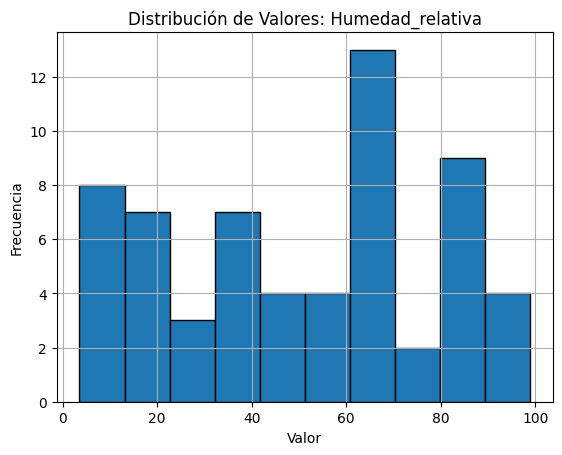

Analizando la tabla: Dirección_del_viento


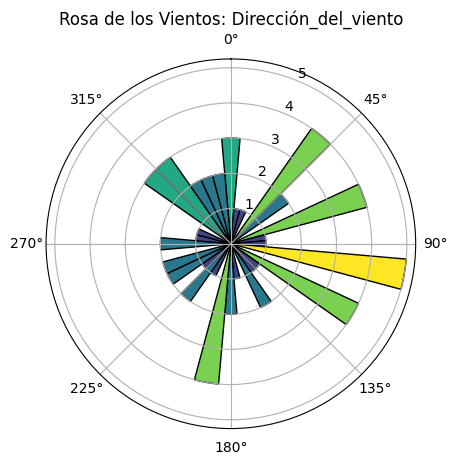

In [23]:

### Primero insertamos el nombre de la base de datos a analizar
db_file = 'resultadoDBold.sqlite'

### Función para convertir Fahrenheit a Celsius (Porque sino las tablas venian en sistema imperial)
def fahrenheit_a_celsius(f):
    return (f - 32) * 5.0 / 9.0

### Mapear tablas comunes en la base de datos
tablas_a_analizar = {
    'Temperatura_mínima': 'Temperatura_mínima',
    'Chuvia': 'Chuvia',
    'Temperatura_media': 'Temperatura_media',
    'Temperatura_máxima': 'Temperatura_máxima',
    'Humedad_relativa': 'Humedad_relativa',
    'Dirección_del_viento': 'Dirección_del_viento'
}

### Conectar a la base de datos SQLite
print(f"\nAnalizando la base de datos: {db_file}")
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

### Obtener todas las tablas existentes en la base de datos
query_tablas = "SELECT name FROM sqlite_master WHERE type='table';"
tablas_existentes = pd.read_sql(query_tablas, conn)['name'].tolist()
print("Tablas existentes en la base de datos:", tablas_existentes)

### Verificar si existen en la base de datos (Por si acaso da problemas)
tablas_validas = {k: v for k, v in tablas_a_analizar.items() if v in tablas_existentes}
print("Tablas válidas para análisis:", list(tablas_validas.keys()))

### Analizamos las tablas
for nombre_logico, nombre_real in tablas_validas.items():
    print(f"Analizando la tabla: {nombre_logico}")
    query = f"""
    SELECT FECHA.Data AS Data, {nombre_real}.valor AS valor
    FROM {nombre_real}
    JOIN FECHA ON {nombre_real}.fecha_id = FECHA.id
    """
    try:
        data = pd.read_sql(query, conn)
        if data.empty:
            print(f"No hay datos para la tabla {nombre_logico}.")
            continue

        data['Data'] = pd.to_datetime(data['Data'])
        data['año'] = data['Data'].dt.year

        if nombre_logico == 'Temperatura_mínima':
            ### Convertir valores a Celsius si están en Fahrenheit
            data['valor'] = fahrenheit_a_celsius(data['valor'])

            ### Filtrar valores atípicos según rangos realistas (Para evitar datos fugados)
            data = data[(data['valor'] >= -20) & (data['valor'] <= 20)]

            ### Gráfico de línea para temperatura mínima
            tendencia = data.groupby('año')['valor'].mean().reset_index()
            plt.figure()
            plt.plot(tendencia['año'], tendencia['valor'], marker='o')
            plt.title(f"Tendencia Anual: {nombre_logico} (°C)")
            plt.xlabel("Año")
            plt.ylabel("Valor Promedio (°C)")
            plt.grid(True)
            plt.show()

        elif nombre_logico == 'Temperatura_media':
            data['valor'] = fahrenheit_a_celsius(data['valor'])

            ### Otra vez el filtro
            data = data[(data['valor'] >= -20) & (data['valor'] <= 50)]

            ### Aplicar filtro de IQR para eliminar valores extremos
            q1 = data['valor'].quantile(0.25)
            q3 = data['valor'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            data = data[(data['valor'] >= lower_bound) & (data['valor'] <= upper_bound)]

            ### Mostrar información de depuración sobre valores descartados
            print(f"Valores descartados en {nombre_logico}: {len(data[data['valor'] < lower_bound]) + len(data[data['valor'] > upper_bound])}")

            ### Gráfico de línea para temperatura media
            tendencia = data.groupby('año')['valor'].mean().reset_index()
            plt.figure()
            plt.plot(tendencia['año'], tendencia['valor'], marker='o')
            plt.title(f"Tendencia Anual: {nombre_logico} (°C)")
            plt.xlabel("Año")
            plt.ylabel("Valor Promedio (°C)")
            plt.grid(True)
            plt.show()

        elif nombre_logico.startswith('Temperatura'):
            data['valor'] = fahrenheit_a_celsius(data['valor'])

            data = data[(data['valor'] >= -50) & (data['valor'] <= 50)]

            
            tendencia = data.groupby('año')['valor'].mean().reset_index()
            plt.figure()
            plt.plot(tendencia['año'], tendencia['valor'], marker='o')
            plt.title(f"Tendencia Anual: {nombre_logico} (°C)")
            plt.xlabel("Año")
            plt.ylabel("Valor Promedio (°C)")
            plt.grid(True)
            plt.show()

        elif nombre_logico == 'Chuvia':
            
            q1 = data['valor'].quantile(0.25)
            q3 = data['valor'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            data = data[(data['valor'] >= lower_bound) & (data['valor'] <= upper_bound)]

            tendencia = data.groupby('año')['valor'].sum().reset_index()
            plt.figure()
            plt.bar(tendencia['año'], tendencia['valor'])
            plt.title(f"Acumulación Anual: {nombre_logico}")
            plt.xlabel("Año")
            plt.ylabel("Total Anual")
            plt.grid(True)
            plt.show()

        elif nombre_logico == 'Humedad_relativa':
            q1 = data['valor'].quantile(0.25)
            q3 = data['valor'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            data = data[(data['valor'] >= lower_bound) & (data['valor'] <= upper_bound)]

            plt.figure()
            plt.hist(data['valor'].dropna(), bins=10, edgecolor='k')
            plt.title(f"Distribución de Valores: {nombre_logico}")
            plt.xlabel("Valor")
            plt.ylabel("Frecuencia")
            plt.grid(True)
            plt.show()

        elif nombre_logico == 'Dirección_del_viento':
            data = data[data['valor'].between(0, 360)]

            ### Rosa de los vientos (Elegi este tipo de grafico porque creo que es la mejor manera de visualizar la direccion de los vientos)
            angulos = np.radians(data['valor'])
            hist, bins = np.histogram(angulos, bins=36, range=(0, 2 * np.pi))
            ax = plt.subplot(111, polar=True)
            bars = ax.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='k', color=cm.viridis(hist / max(hist)))
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            plt.title(f"Rosa de los Vientos: {nombre_logico}")
            plt.show()

    except Exception as e:
        print(f"No se pudo analizar la tabla {nombre_logico}: {e}")

### Cerramos la conexion
conn.close()

Gracias a este codigo podemos observar gráficamente las tendencias y valores medios para realizar comparativas



Analizando la base de datos: resultadoDB.sqlite
Tablas existentes en la base de datos: ['resultado', 'Parametros', 'sqlite_sequence', 'FECHA', 'Chuvia', 'Chuvia_diaria_máxima', 'Dirección_do_refacho_a_2m', 'Dirección_do_vento_predominante_a_2m', 'Chuvia_diaria_m_xima', 'Direcci_n_do_refacho_a_2m', 'Direcci_n_do_vento_predominante_a_2m', 'Horas_de_fr_o_____7_C_', 'Horas_humidade_foliar_mensuais', 'Humidade_media_das_m_ximas_a_1_5m', 'Humidade_media_das_m_nimas_a_1_5m', 'Humidade_relativa_media_a_1_5m', 'N_mero_de_d_as_de_chuvia___0L_m2_', 'N_mero_de_d_as_de_chuvia___10L_m2_', 'N_mero_de_d_as_de_chuvia___1L_m2_', 'N_mero_de_d_as_de_chuvia___30L_m2_', 'N_mero_de_d_as_de_chuvia___60L_m2_', 'N_mero_de_d_as_de_xeada', 'Presi_n', 'Presi_n_reducida', 'Refacho_m_ximo_a_2m', 'Temperatura__media_das_m_nimas_a_1_5m', 'Temperatura_de_orballo_a_1_5m', 'Temperatura_do_solo_a__0_1m', 'Temperatura_m_xima_a_1_5m', 'Temperatura_media_a_0_1m', 'Temperatura_media_a_1_5m', 'Temperatura_media_das_m_ximas_a_

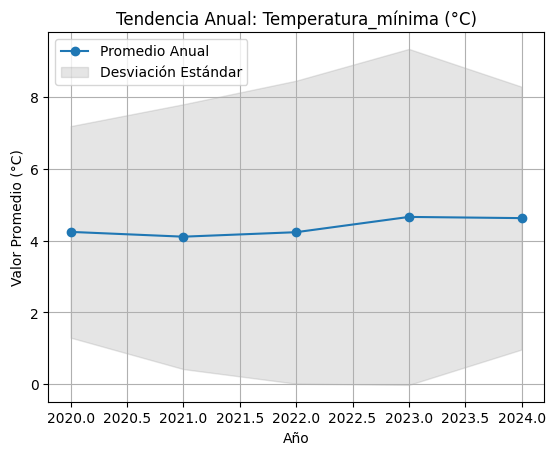

Analizando la tabla: Chuvia


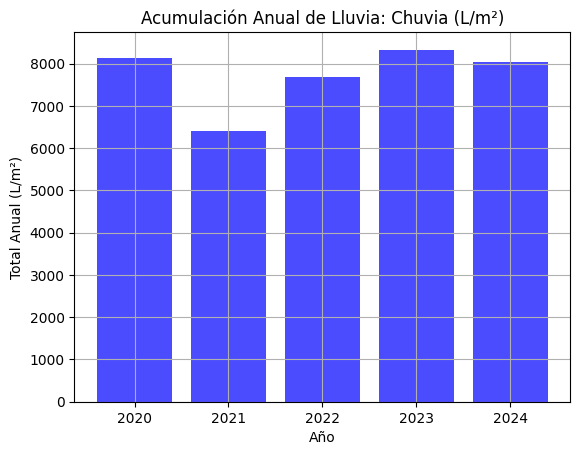

Acumulación anual de lluvia (L/m²):
    año   valor
0  2020  8137.2
1  2021  6416.4
2  2022  7685.4
3  2023  8331.0
4  2024  8033.1
Analizando la tabla: Temperatura_media


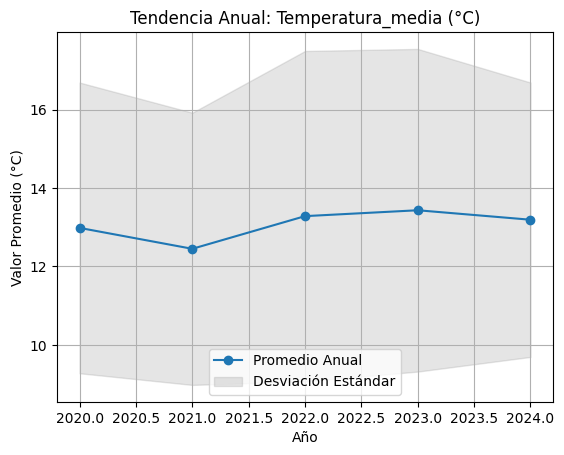

Analizando la tabla: Temperatura_máxima


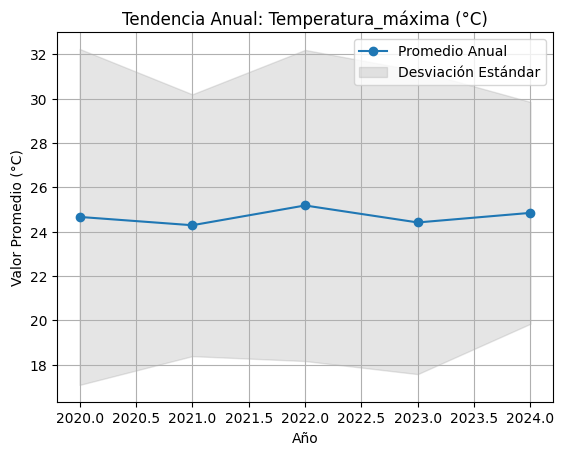

Analizando la tabla: Humedad_relativa


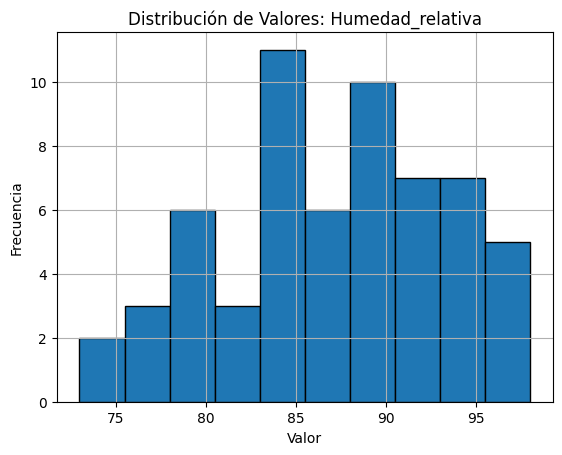

Analizando la tabla: Dirección_del_viento


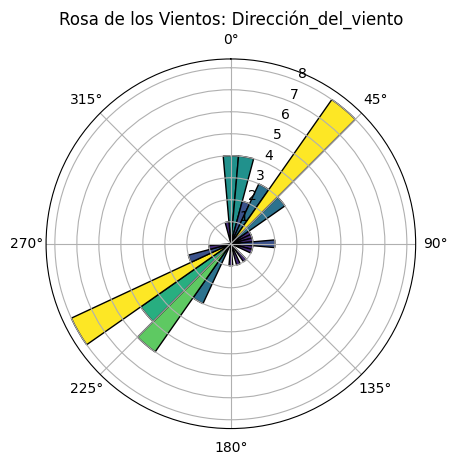

In [28]:

### Primero insertamos el nombre de la base de datos a analizar
db_file = 'resultadoDB.sqlite'

### Mapear tablas comunes en la base de datos
tablas_a_analizar = {
    'Temperatura_mínima': 'Temperatura_m_nima_a_1_5m',
    'Chuvia': 'Chuvia',
    'Temperatura_media': 'Temperatura_media_a_1_5m',
    'Temperatura_máxima': 'Temperatura_m_xima_a_1_5m',
    'Humedad_relativa': 'Humidade_relativa_media_a_1_5m',
    'Dirección_del_viento': 'Dirección_do_refacho_a_2m'
}

### Conectar a la base de datos SQLite
print(f"\nAnalizando la base de datos: {db_file}")
conn = sqlite3.connect(db_file)
cursor = conn.cursor()

### Obtener todas las tablas existentes en la base de datos
query_tablas = "SELECT name FROM sqlite_master WHERE type='table';"
tablas_existentes = pd.read_sql(query_tablas, conn)['name'].tolist()
print("Tablas existentes en la base de datos:", tablas_existentes)

### Verificar si existen en la base de datos (Por si acaso da problemas)
tablas_validas = {k: v for k, v in tablas_a_analizar.items() if v in tablas_existentes}
print("Tablas válidas para análisis:", list(tablas_validas.keys()))

### Analizamos las tablas
tablas_resultantes = {}
for nombre_logico, nombre_real in tablas_validas.items():
    print(f"Analizando la tabla: {nombre_logico}")
    query = f"""
    SELECT FECHA.Data AS Data, {nombre_real}.valor AS valor
    FROM {nombre_real}
    JOIN FECHA ON {nombre_real}.fecha_id = FECHA.id
    """
    try:
        data = pd.read_sql(query, conn)
        if data.empty:
            print(f"No hay datos para la tabla {nombre_logico}.")
            continue

        data['Data'] = pd.to_datetime(data['Data'])
        data['año'] = data['Data'].dt.year

        if nombre_logico.startswith('Temperatura'):
            

            ### Filtrar valores atípicos según rangos realistas (Para evitar datos fugados)
            data = data[(data['valor'] >= -50) & (data['valor'] <= 50)]

            ### Guardar datos en tabla resultante
            tablas_resultantes[nombre_logico] = data

            ### Gráfico de línea para temperaturas
            tendencia = data.groupby('año')['valor'].mean().reset_index()
            plt.figure()
            plt.plot(tendencia['año'], tendencia['valor'], marker='o', label='Promedio Anual')
            plt.fill_between(tendencia['año'], tendencia['valor'] - data.groupby('año')['valor'].std().reset_index()['valor'],
                             tendencia['valor'] + data.groupby('año')['valor'].std().reset_index()['valor'],
                             color='gray', alpha=0.2, label='Desviación Estándar')
            plt.title(f"Tendencia Anual: {nombre_logico} (°C)")
            plt.xlabel("Año")
            plt.ylabel("Valor Promedio (°C)")
            plt.legend()
            plt.grid(True)
            plt.show()

        elif nombre_logico == 'Chuvia':
            ### Aplicar filtro de IQR para eliminar valores extremos
            q1 = data['valor'].quantile(0.25)
            q3 = data['valor'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            data = data[(data['valor'] >= lower_bound) & (data['valor'] <= upper_bound)]

            ### Calcular acumulación anual de lluvia
            tendencia = data.groupby('año')['valor'].sum().reset_index()

            ### Guardar datos en tabla resultante
            tablas_resultantes[nombre_logico] = tendencia

            plt.figure()
            plt.bar(tendencia['año'], tendencia['valor'], color='blue', alpha=0.7)
            plt.title(f"Acumulación Anual de Lluvia: {nombre_logico} (L/m²)")
            plt.xlabel("Año")
            plt.ylabel("Total Anual (L/m²)")
            plt.grid(True)
            plt.show()

            print(f"Acumulación anual de lluvia (L/m²):\n{tendencia}")

        elif nombre_logico == 'Humedad_relativa':
            q1 = data['valor'].quantile(0.25)
            q3 = data['valor'].quantile(0.75)
            iqr = q3 - q1
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr
            data = data[(data['valor'] >= lower_bound) & (data['valor'] <= upper_bound)]

            ### Guardar datos en tabla resultante
            tablas_resultantes[nombre_logico] = data

            plt.figure()
            plt.hist(data['valor'].dropna(), bins=10, edgecolor='k')
            plt.title(f"Distribución de Valores: {nombre_logico}")
            plt.xlabel("Valor")
            plt.ylabel("Frecuencia")
            plt.grid(True)
            plt.show()

        elif nombre_logico == 'Dirección_del_viento':
            data = data[data['valor'].between(0, 360)]

            ### Rosa de los vientos (Elegí este tipo de gráfico porque creo que es la mejor manera de visualizar la dirección de los vientos)
            angulos = np.radians(data['valor'])
            hist, bins = np.histogram(angulos, bins=36, range=(0, 2 * np.pi))
            ax = plt.subplot(111, polar=True)
            bars = ax.bar(bins[:-1], hist, width=np.diff(bins), edgecolor='k', color=cm.viridis(hist / max(hist)))
            ax.set_theta_zero_location('N')
            ax.set_theta_direction(-1)
            plt.title(f"Rosa de los Vientos: {nombre_logico}")
            plt.show()

    except Exception as e:
        print(f"No se pudo analizar la tabla {nombre_logico}: {e}")



### Cerramos la conexión
conn.close()
